# Trying to to release particles on several days --> timeps


- [ ] Check release time and locations for Sanchi oil spill (Kuroshio)
Sinking: 14th January 2018 (16:45 local time?)
HFO spilled
First island to be impacted was Takarajima, in the very end of January (29-31?). The other island to be badly affected was Amami (and the adjacent southern islands). Contamination affected also Kikaijima and Tokunojima. Other islands, both north and south of this core, were affected, but with low amounts of oil. We can discuss this later on.
All of this can be gathered through news online. There are also papers, but careful with these, there was lots of bad science done regarding trajectory of the oil and impacts.
 
—> exact coords of sinking? 

my estimate from screenshot:
28°25'01.3"N 125°54'24.7"E

28.417036, 125.906860

—> release every 1hr until the 23
<br>
  - [x] need to read arcGIS data sent by duarte (/Users/Gomez023/Documents/postdoc_docs/Projects/WOC_proj/Oil/Duarte_Sanchi_spill/SANCHI_CONFIDENTIAL/) in python!!
<br>

https://desktop.arcgis.com/es/arcmap/latest/analyze/arcpy-mapping/getting-started-with-arcpy-mapping-tutorial.htm 

<br>

http://localhost:8888/notebooks/test_arcgis_data_reading.ipynb 

<br>
            - [x] test with Sanchi data now: 
<br>

                - [x] 
                
http://localhost:8888/notebooks/2022-04-28_test_arcgis_data_reading_Sanchi.ipynb
                
                —> works!!!!!

- [ ] 


In [1]:
#%matplotlib inline
from parcels import Field, FieldSet, ParticleSet, JITParticle,  AdvectionRK4, ErrorCode, DiffusionUniformKh
import numpy as np
from datetime import timedelta, datetime
import xarray as xr

import pytz
from netCDF4 import num2date, date2num

In [2]:
import sys

sys.path.insert(0, "/storage/home/gomez023/WOC_ESA/")

from add_WOC_nc_attbts_v02 import *

In [3]:
data_path_v02 = '/storage/shared/oceanparcels/output_data/data_LauraGN/WOC/v02_current_data/separate_components/KUR/'
fname_v02 = 'runconv15m_kur2_d24*.nc' 

In [4]:
ds = xr.open_mfdataset(data_path_v02 + fname_v02)

In [5]:
ds

<xarray.Dataset>
Dimensions:   (lon: 81, lat: 61, time: 720)
Coordinates:
  * lon       (lon) float32 120.0 120.2 120.5 120.8 ... 139.2 139.5 139.8 140.0
  * lat       (lat) float32 20.0 20.25 20.5 20.75 21.0 ... 34.25 34.5 34.75 35.0
  * time      (time) float64 2.484e+04 2.484e+04 ... 2.487e+04 2.487e+04
Data variables:
    U         (time, lat, lon) float32 dask.array<chunksize=(24, 61, 81), meta=np.ndarray>
    V         (time, lat, lon) float32 dask.array<chunksize=(24, 61, 81), meta=np.ndarray>
    U_CMEMS   (time, lat, lon) float32 dask.array<chunksize=(24, 61, 81), meta=np.ndarray>
    V_CMEMS   (time, lat, lon) float32 dask.array<chunksize=(24, 61, 81), meta=np.ndarray>
    UG_CMEMS  (time, lat, lon) float32 dask.array<chunksize=(24, 61, 81), meta=np.ndarray>
    VG_CMEMS  (time, lat, lon) float32 dask.array<chunksize=(24, 61, 81), meta=np.ndarray>
    UA_ERA5   (time, lat, lon) float32 dask.array<chunksize=(24, 61, 81), meta=np.ndarray>
    VA_ERA5   (time, lat, lon) float32 dask.array<chunksize=(24, 61, 81), meta=np.ndarray>
Attributes:
    description:   WOC theme 3

In [6]:
ds.lon.data.min()

120.0

In [7]:
ds.lon.data.max()

140.0

## Total vel. is:
# (ds.UG_CMEMS[0,:,:] + ds.U[0,:,:])

# --> trying then with not the 24 hrs just 00h:

In [8]:
timestamps_all = np.expand_dims(np.array([np.datetime64('2018-01-%.2d 00:00:00' %d) for d in range(1,31)]), axis=1)
#     timestamps_all = np.vstack((timestamps_all,timestamps))
timestamps_all

array([['2018-01-01T00:00:00'],
       ['2018-01-02T00:00:00'],
       ['2018-01-03T00:00:00'],
       ['2018-01-04T00:00:00'],
       ['2018-01-05T00:00:00'],
       ['2018-01-06T00:00:00'],
       ['2018-01-07T00:00:00'],
       ['2018-01-08T00:00:00'],
       ['2018-01-09T00:00:00'],
       ['2018-01-10T00:00:00'],
       ['2018-01-11T00:00:00'],
       ['2018-01-12T00:00:00'],
       ['2018-01-13T00:00:00'],
       ['2018-01-14T00:00:00'],
       ['2018-01-15T00:00:00'],
       ['2018-01-16T00:00:00'],
       ['2018-01-17T00:00:00'],
       ['2018-01-18T00:00:00'],
       ['2018-01-19T00:00:00'],
       ['2018-01-20T00:00:00'],
       ['2018-01-21T00:00:00'],
       ['2018-01-22T00:00:00'],
       ['2018-01-23T00:00:00'],
       ['2018-01-24T00:00:00'],
       ['2018-01-25T00:00:00'],
       ['2018-01-26T00:00:00'],
       ['2018-01-27T00:00:00'],
       ['2018-01-28T00:00:00'],
       ['2018-01-29T00:00:00'],
       ['2018-01-30T00:00:00']], dtype='datetime64[s]')

In [9]:
filenames = {'U': data_path_v02 + fname_v02, 'V': data_path_v02 + fname_v02}
variables = {'U': 'UG_CMEMS', 'V': 'VG_CMEMS'}
dimensions = {'U': {'lat': 'lat', 'lon': 'lon', 'time': 'time'},
              'V': {'lat': 'lat', 'lon': 'lon', 'time': 'time'}} #, 'depth': 'depth'
#indices = {'depth': [0]} # choosing 00m depth
fieldset_UG_CMEMS = FieldSet.from_netcdf(filenames, variables, dimensions, timestamps=timestamps_all)


In [10]:
filenames = {'U': data_path_v02 + fname_v02, 'V': data_path_v02 + fname_v02}
variables = {'U': 'U', 'V': 'V'}
dimensions = {'U': {'lat': 'lat', 'lon': 'lon', 'time': 'time'},
              'V': {'lat': 'lat', 'lon': 'lon', 'time': 'time'}} #, 'depth': 'depth'
#indices = {'depth': [0]} # choosing 00m depth
fieldset_Uageos = FieldSet.from_netcdf(filenames, variables, dimensions, timestamps=timestamps_all)


In [11]:
# print(pset_v2.particle_data['time'][0]) 

In [12]:
fieldset_UG_CMEMS.time_origin

2018-01-01T00:00:00

In [13]:
fieldset_total = FieldSet(U=fieldset_UG_CMEMS.U + fieldset_Uageos.U, V=fieldset_UG_CMEMS.V + fieldset_Uageos.V)


# Particle release:

In [14]:
# Oil release location approx:
# 125.95E, 28.36N

# --> we do mesh (min lon to max lon 13km, so more than first rossby radius to take into account structures present not exactly on at same position!)

lons_list=[125.89, 125.91, 125.93, 125.95, 125.97, 125.99, 126.01]
lats_list=[28.30, 28.32, 28.34, 28.36, 28.38, 28.40, 28.42]

In [15]:
np.array(lons_list)

array([125.89, 125.91, 125.93, 125.95, 125.97, 125.99, 126.01])

In [16]:
# step = .25 # degrees
# lons, lats = np.meshgrid(np.arange(125., 126.+step, step), np.arange(28, 29+step, step))
lons, lats = np.meshgrid(np.array(lons_list), np.array(lats_list))

lons.shape[0]*lons.shape[1]

49

In [17]:
timep = datetime(2018,1,14)
timep

datetime.datetime(2018, 1, 14, 0, 0)

In [18]:
from datetime import timedelta as delta

repeatdt = delta(hours=1.)  # release from the same set of locations every 3 hours

# Running simu:

In [19]:
pset_v2 = ParticleSet(fieldset=fieldset_total, pclass=JITParticle, lon=lons, lat=lats, time=timep, repeatdt=repeatdt)


In [20]:
# outdir =  "/storage/shared/oceanparcels/output_data/data_LauraGN/WOC/Oil/v02/"
outdir =  "/storage/shared/oceanparcels/output_data/data_LauraGN/WOC/Oil/v02/new/"

file_name = "test03_v02_KUR_Jan2018_cont1h_MESH_repeatDt.nc"
# file_name = "20110910000000-WOC-L4-CURlag-NATL_oil_spill_drift_1H_00m_instantaneous-v1.0-fv1.0.nc"

In [21]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()

In [22]:
timep.isoformat()

'2018-01-14T00:00:00'

In [23]:
output_file = pset_v2.ParticleFile(name=outdir + file_name, outputdt=timedelta(hours=1))

#runtime from 14/01/2018 till 30/01/2018 (31st Jan not in dataset), so 16 days
pset_v2.execute(pset_v2.Kernel(AdvectionRK4), runtime=timedelta(days=16.), dt=timedelta(minutes=10),
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle}, output_file=output_file)

start_time = timep.isoformat() #time_long[0].isoformat()
# Check in case it's not NaN:
# print(pset_v2.particle_data['time'][0]) #modify to assert 
time_unit_out= "seconds since " + str(pset_v2.time_origin)
# end_time = (num2date(pset_v2.particle_data['time'][0], time_unit_out)).isoformat()
end_time = (num2date(output_file.lasttime_written, time_unit_out)).isoformat()

add_WOC_nc_attbts(output_file, start_time, end_time, ds.lon.data.min(), ds.lon.data.max(), ds.lat.data.min(), ds.lat.data.max()
        , input_filename="WOC-L4-CUReul-KUR-1H: runconv15m_kur2_d24*.nc"
        , ntitle="Kuroshio region 2D horizontal drift of oil spill for ESA WOC project" 
        , summary="This dataset contains the positions of virtual particles released hourly from 14/01/2018 till the 23/01/2018 at 15m representing the trajectories of an oil spill event in the Kuroshio region."
        , inid = "KUR_OIL_SPILL_DRIFT_1H_CONT"
        , ndepth = "15")

output_file.export()  # exports the trajectory data to a netcdf file



sh: None: command not found
INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /tmp/parcels-319202/libf06f51afaabc8c87ae3e8d2c6687d5f7_0.so
INFO: Temporary output files are stored in /storage/shared/oceanparcels/output_data/data_LauraGN/WOC/Oil/v02/new/out-XPZHSRBS.
INFO: You can use "parcels_convert_npydir_to_netcdf /storage/shared/oceanparcels/output_data/data_LauraGN/WOC/Oil/v02/new/out-XPZHSRBS" to convert these to a NetCDF file during the run.
100% (1382400.0 of 1382400.0) |##########| Elapsed Time: 0:00:12 Time:  0:00:12
/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [24]:
!ls -trl /storage/shared/oceanparcels/output_data/data_LauraGN/WOC/Oil/v02/new/

total 198616
drwxr-xr-x 3 gomez023 U_UPG_Gomez023_P        23 May 11 22:04 out-XPZHSRBS
-rw-r--r-- 1 gomez023 U_UPG_Gomez023_P 203382710 May 11 22:05 test03_v02_KUR_Jan2018_cont1h_MESH_repeatDt.nc


In [25]:
!rm -rf /storage/shared/oceanparcels/output_data/data_LauraGN/WOC/Oil/v02/new/out-*

In [26]:
!ncdump -h /storage/shared/oceanparcels/output_data/data_LauraGN/WOC/Oil/v02/new/test03_v02_KUR_Jan2018_cont1h_MESH_repeatDt.nc


netcdf test03_v02_KUR_Jan2018_cont1h_MESH_repeatDt {
dimensions:
	obs = 385 ;
	traj = 18865 ;
variables:
	int64 trajectory(traj, obs) ;
		trajectory:_FillValue = -9223372036854775808LL ;
		trajectory:long_name = "Unique identifier for each particle" ;
		trajectory:cf_role = "trajectory_id" ;
	double time(traj, obs) ;
		time:_FillValue = NaN ;
		time:long_name = "" ;
		time:standard_name = "time" ;
		time:units = "seconds since 2018-01-01T00:00:00" ;
		time:calendar = "standard" ;
		time:axis = "T" ;
	float lat(traj, obs) ;
		lat:_FillValue = NaNf ;
		lat:long_name = "" ;
		lat:standard_name = "latitude" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
	float lon(traj, obs) ;
		lon:_FillValue = NaNf ;
		lon:long_name = "" ;
		lon:standard_name = "longitude" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
	float z(traj, obs) ;
		z:_FillValue = NaNf ;
		z:long_name = "" ;
		z:standard_name = "depth" ;
		z:units = "m" ;
		z:positive = "down" ;

// global attributes:
		:feature_type

In [27]:
from datetime import timedelta, datetime
from glob import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import colors 

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [28]:
ds = xr.open_dataset(outdir + file_name)

In [29]:
pwd

'/storage/home/gomez023/WOC_ESA/Oil_spills/v02/Kuroshio'

In [30]:
ds


<xarray.Dataset>
Dimensions:     (traj: 18865, obs: 385)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
Attributes: (12/57)
    feature_type:                  trajectory
    Conventions:                   CF-1.7, ACDD-1.3, ISO 8601
    ncei_template_version:         NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:               2.3.1.dev20+g92f2fb90
    parcels_mesh:                  spherical
    Metadata_Conventions:          Climate and Forecast (CF) 1.7, Attribute C...
    ...                            ...
    date_modified:                 2022-05-06T15:11:36
    source:                        parcels
    source_version:                2.3.1.dev20+g92f2fb90
    history:                       2022-05-06T15:11:36 - Creation
    input:                         WOC-L4-CUReul-KUR-1H: runconv15m_kur2_d24*.nc
    processing_software:           parcels

/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


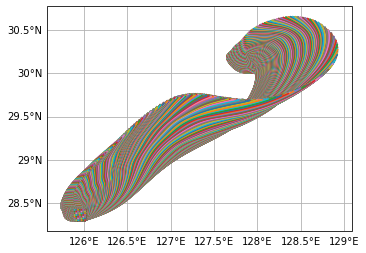

In [31]:
plt.figure(figsize=(12,10)) #(17,5)

ax1 = plt.subplot(121, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree()) #marker='o'
# ax1.set_xlim([6, 12])
# ax1.set_ylim([52, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# --> looks good!

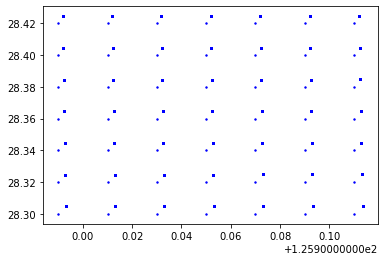

In [35]:
plt.scatter(ds.lon[:,0], ds.lat[:,0], c='b', s=2, label='Release locs.')


# --> why second point?

In [41]:
ds.lon[47:52,0].values

array([125.99    , 126.01    , 125.892975, 125.91304 , 125.933105],
      dtype=float32)

In [40]:
ds.lon[47:52,0].values

array([125.99    , 126.01    , 125.892975, 125.91304 , 125.933105],
      dtype=float32)

In [33]:
print(ds.lon[0,0].values)
print(ds.lon[0+49,0].values)

125.89
125.892975


In [34]:
print(ds.lon[0+49+49,0].values)

125.892975


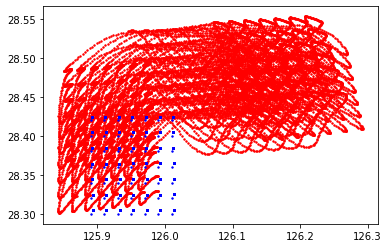

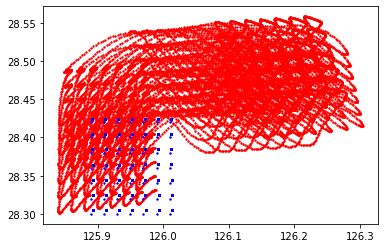

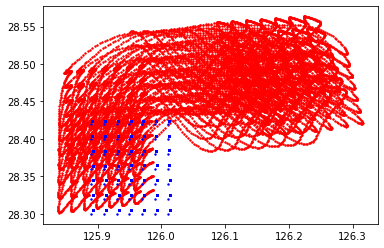

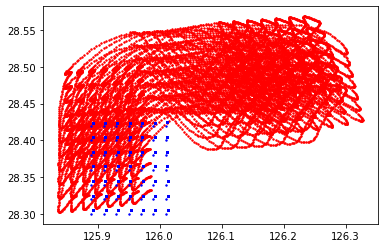

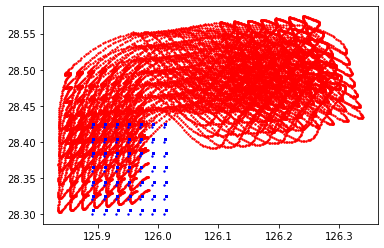

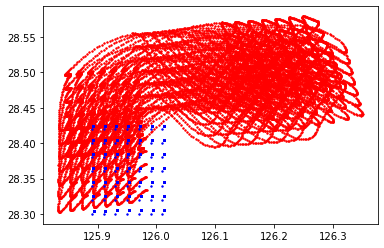

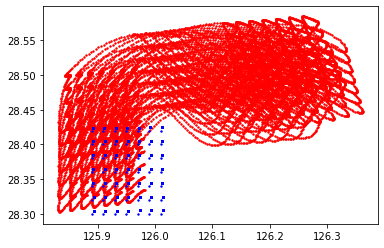

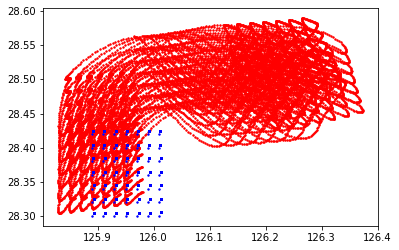

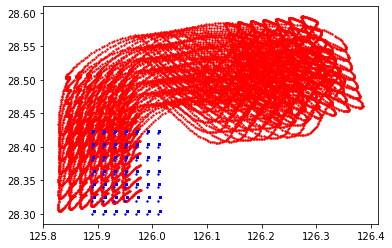

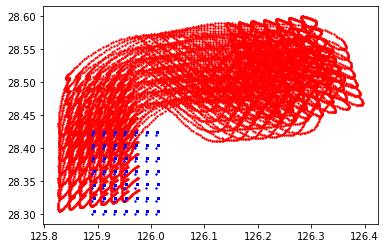

In [34]:
for ii in range(24,24+10):
    plt.figure()
    plt.scatter(ds.lon[:,ii], ds.lat[:,ii], c='r', s=2, label='Release locs.')
    plt.scatter(ds.lon[:,0], ds.lat[:,0], c='b', s=2, label='Release locs.')
    plt.show()

In [37]:
24*10*49

11760

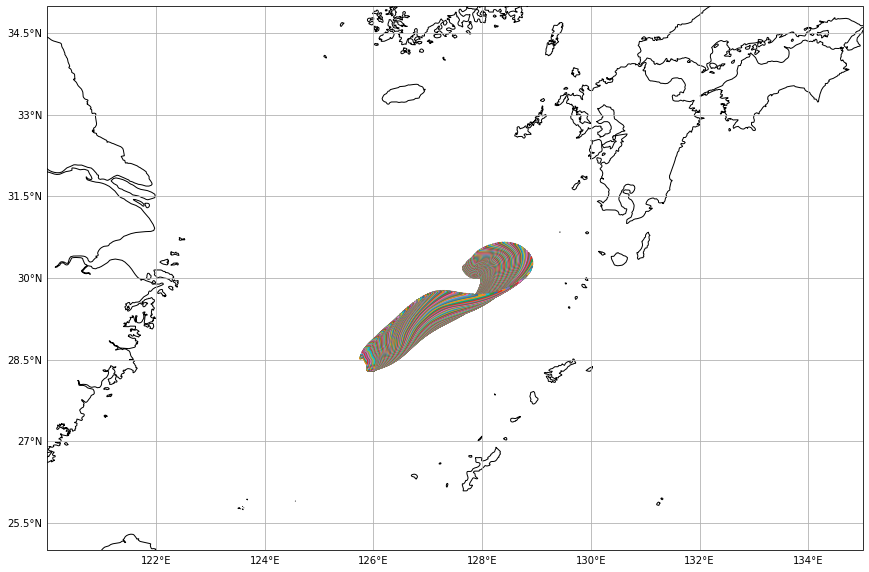

In [38]:
plt.figure(figsize=(16,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='10m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.plot(ds['lon'][0:11760,:].T, ds['lat'][0:11760,:].T, transform=ccrs.PlateCarree()) #marker='o'
ax1.set_xlim([120, 135])
ax1.set_ylim([25, 35])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

In [39]:
gskjdkghsd

NameError: name 'gskjdkghsd' is not defined

# Previous version:

/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


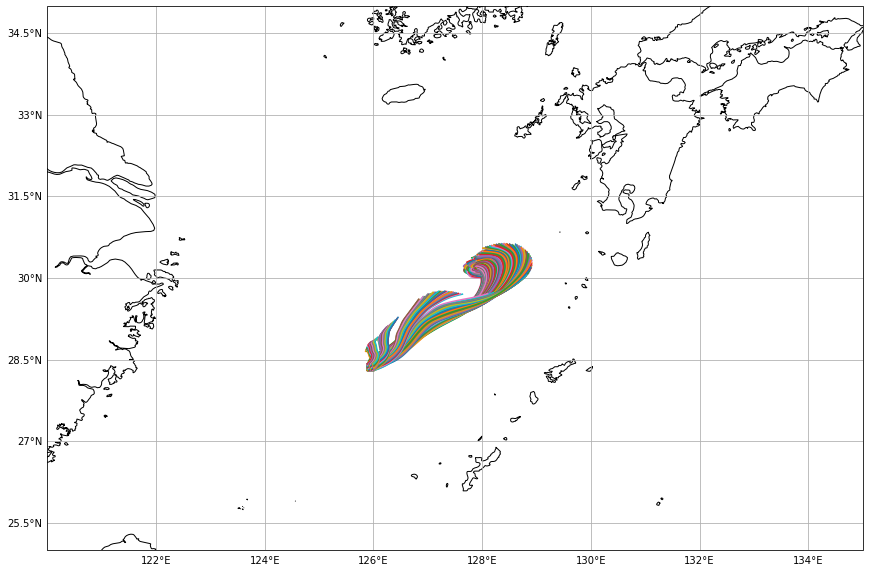

In [49]:
plt.figure(figsize=(16,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='10m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree()) #marker='o'
ax1.set_xlim([120, 135])
ax1.set_ylim([25, 35])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# --> different!!